In [1]:
## import lib
from sklearn.datasets import load_boston
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter

carico il dataset e lo suddivido in training e testing set

In [2]:
np.random.seed(123) ## seed manuali in modo che il notebook sia ripetibile 
torch.random.manual_seed(123)

boston = load_boston()
X = boston.data
Y = boston.target

idx = np.random.permutation(len(X)) ##permutazione degli indici

X = X[idx]
Y = Y[idx]

X_training = torch.Tensor(X[50:])
Y_training = torch.Tensor(Y[50:])
X_testing = torch.Tensor(X[:50])
Y_testing = torch.Tensor(Y[:50])

In [3]:
### https://it.wikipedia.org/wiki/Modello_logit

class LinearRegressor(nn.Module):
  def __init__(self, in_size, out_size):
    """
    Regressore logistico in_size: numero di feature in input, out_size: numero di elementi in output
    """
    super(LinearRegressor, self).__init__() ## richiamo il costruttore della superclasse

    self.linear = nn.Linear(in_size, out_size)

  def forward(self,x):
    """ come processare input x """
    result = self.linear(x)

    return result

alleno il regressore lineare

In [4]:
lr = 0.01
epochs = 300

writer = SummaryWriter('logs/linear_regressor_1')

## norm
means = X_training.mean(0)
stds = X_training.std(0)

X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds

reg = LinearRegressor(13, 1)
criterion = nn.MSELoss()

optimizer = torch.optim.SGD(reg.parameters(), lr=lr)

for e in range(epochs):
  reg.train() ## modello in modalità training
  output = reg(X_training_norm)

  l = criterion(output.view(-1), Y_training)

  writer.add_scalar('loss/train', l.item(), global_step=e)
  l.backward()
  optimizer.step()
  optimizer.zero_grad()

  reg.eval()  ## modello è in modalità evaluation (test, alcuni moduli in fase di test si comportano diversamente)

  ## controllo che l'algoritmo funzioni bene o no:
  with torch.set_grad_enabled(False):
    y_test = reg(X_testing_norm)
    l = criterion(y_test.view(-1), Y_testing)
    writer.add_scalar('loss/test', l.item(), global_step=e)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Valutazione di un regressore lineare

Usiamo il modello per predire le etichette sia per il training che per il test set

In [5]:
preds_training = reg(X_training_norm)
preds_testing = reg(X_testing_norm)

Un modo semplice per valutare il modello consiste col calcolare l'MSE.

In [6]:
def MSE(predictions, gt):
  ## inseriamo un assert per assicurarci che le due shape siano compatibili 
  ## questo serve ad evitare problemi introdotti dal broadcasting
  assert predictions.shape == gt.shape
  return ((predictions-gt)**2).mean()

## quando si utilizza MSE facciamo un reshape per le predizioni in modo che da shape [Nx1] diventino di shape [1]

print("Mean Squared Error (MSE) di training: {:0.2f}".format(MSE(preds_training.view(-1),Y_training)))
print("Mean Squared Error (MSE) di testing: {:0.2f}".format(MSE(preds_testing.view (-1),Y_testing)))


Mean Squared Error (MSE) di training: 20.52
Mean Squared Error (MSE) di testing: 44.04


l'unità di misura dell'MSE è la stessa unità dei dati al quadrato. Dato che i target del dataset considerato si misurano in migliaia di dollari, l'errore riportato è in migliaia di dollari al quadrato. Se vogliamo avere un errore nella stessa unità di misura dei dati in ingresso, definiamo RMSE (con radice quadrata

In [7]:
def RMSE(predictions, gt):
  assert predictions.shape == gt.shape
  return ((predictions-gt)**2).mean()**(1/2)

## Gli errori adesso ci dicono quanto il modello sbaglia in media in "migliaia di errori".
print("Root Mean Squared Error (RMSE) di training: {:0.2f}".format(RMSE(preds_training.view(-1),Y_training))) ### errore di circa 4000
print("Root Mean Squared Error (RMSE) di testing: {:0.2f}".format(RMSE(preds_testing.view(-1),Y_testing)))

Root Mean Squared Error (RMSE) di training: 4.53
Root Mean Squared Error (RMSE) di testing: 6.64


Un ulteriore misura di errore generalmente utilizzata è il **Mean Absolute Error** (MAE), che consiste nel calcolare la media dei valori assoluti delle differenze tra valori predetti e valori di ground truth. Anche in questo caso l'unità di misura è la stessa dei valori di target. Implementiamo la misura di errore e calcoliamo errore su training e test set:

In [8]:
def MAE(predictions, gt):
  assert predictions.shape == gt.shape
  return ((predictions-gt).abs()).mean()

## si tende ad usare poco perché il valore assoluto considera solo valori positivi ed in alcuni casi non è corretto
## tende ad appiattire i dati. Si usa spesso xke ha buone proprietà geometriche
print("Mean Absolute Error (MAE) di training: {:0.2f}".format(MAE(preds_training.view(-1),Y_training)))
print("Mean Absolute Error (MAE) di testing: {:0.2f}".format(MAE(preds_testing.view (-1),Y_testing)))

Mean Absolute Error (MAE) di training: 3.08
Mean Absolute Error (MAE) di testing: 4.31


Un altro modo per valutare un regressore, consiste nel costruire una curva REC(Regression Error Curve). La curva riporta sull'asse delle x una serie di soglie di tolleranza e sull'asse delle y la percentuale degli elementi di test che presentano un errore inferiore o uguale alla soglia corrispondente. Inoltre, alla curva è spesso associata l'area sopra la curva (AOC) per offrire una misura dell'errore del metodo. Definiamo una funzione:

In [9]:
def rec_curve(predictions, gt):
  assert predictions.shape == gt.shape  ### with assert you're telling the program to test that condition, and immediately trigger an error if the condition is false.
  #calcoliamo tutti gli errori mediante MAE
  errors = np.abs(np.array((predictions.detach()-gt))) #prendiamo i valori unici degli erorri e ordiniamoli ## detach per evitare di calcolare i gradienti
  tolerances = sorted(np.unique(errors))
  correct= [] #lista delle "accuracy" relative a ogni soglia
  for t in tolerances:
    correct.append((errors<=t).mean()) #frazione di elementi "correttamente" re gressi
  
  AUC = np.trapz(correct, tolerances) #area sotto la curva calcolata col metodo d ei trapezi https://it.openprof.com/wb/calcolo_numerico_di_integrali_definiti?ch=518
  tot_area = np.max(tolerances)*1 #area totale
  AOC = tot_area - AUC

  #restituiamo le soglie, la frazione di campioni correttamente regressi e l'area sopra la curva
  return tolerances, correct, AOC

calcolo curva REC e faccio il plot

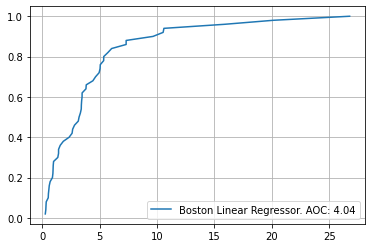

In [10]:
boston_linear_regressor_rec = rec_curve(preds_testing.view(-1), Y_testing)
plt.plot(boston_linear_regressor_rec[0], boston_linear_regressor_rec[1])
plt.legend(['Boston Linear Regressor. AOC: %0.2f'%boston_linear_regressor_rec[2]])
plt.grid()
plt.show()

In pratica, le curve REC possono essere molto utili per confrontare le performance di due regressori diversi. Confrontiamo ad esempio le performance del regressore su training e test set:



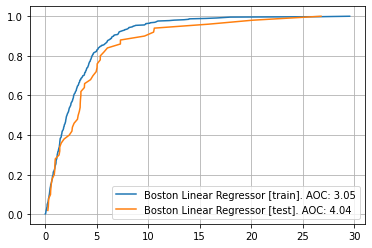

In [11]:
boston_linear_regressor_training_rec = rec_curve(preds_training.view(-1),Y_training)
boston_linear_regressor_testing_rec = rec_curve(preds_testing.view(-1),Y_testing)
plt.plot(boston_linear_regressor_training_rec[0], boston_linear_regressor_training_rec[1])
plt.plot(boston_linear_regressor_testing_rec[0], boston_linear_regressor_testing_rec[1])
plt.legend(['Boston Linear Regressor [train]. AOC: %0.2f'%boston_linear_regressor_training_rec[2],'Boston Linear Regressor [test]. AOC: %0.2f'%boston_linear_regressor_testing_rec[2]])
plt.grid()
plt.show()

# Regressione logistica in pytorch

implementazione ed allenamento di un regressore logistico. consideriamo come esempio il dataset breast-cancer

In [12]:
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()
X=dataset.data
Y=dataset.target #features
print(X.shape)
#classi target
print(Y.shape)
print(Y[:100])

### spiegazioni su scelte implementative e dataset nel pdf



(569, 30)
(569,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0]


(teoria e formule su pdf).
un regressore logistico si può vedere come un regressore lineare al quale output è stata applicata la funzione logistica. Vediamo come implementarlo. Impostiamo un seed per avere risultati ripetibili:

In [13]:
np.random.seed(1234)
torch.random.manual_seed(1234)

## permutazione casuale dei dati
idx = np.random.permutation(len(X))

## applico la stessa a X e Y
X = X[idx]
Y = Y[idx]

## seleziono i primi 100 valori per formare il testing e il training. non dobbiamo specificare require_grad=True perché saranno osservazioni che non si andranno ad ottimizzare

X_training = torch.Tensor(X[100:])
Y_training = torch.Tensor(Y[100:])
X_testing = torch.Tensor(X[:100])
Y_testing = torch.Tensor(Y[:100])

## normalizzo dati per media e dev std

X_mean = X_training.mean(0)
X_std = X_training.std(0)
X_training_norm = (X_training-X_mean)/X_std
X_testing_norm = (X_testing-X_mean)/X_std

print(X_testing_norm, X_testing_norm)

tensor([[-0.7085,  0.1491, -0.7009,  ..., -0.5163,  0.5046,  0.2910],
        [-0.9547, -2.2491, -0.9653,  ..., -1.0502, -1.3320, -0.3815],
        [-0.4878, -0.6906, -0.3874,  ...,  0.2882,  0.5458,  1.0383],
        ...,
        [-0.6039,  2.0379, -0.6336,  ..., -0.9069, -0.8153, -0.9513],
        [-1.4957, -1.1023, -1.3749,  ..., -1.0224, -1.0621,  1.3071],
        [-0.8076,  1.7913, -0.8425,  ..., -1.4327, -0.0829, -0.7105]]) tensor([[-0.7085,  0.1491, -0.7009,  ..., -0.5163,  0.5046,  0.2910],
        [-0.9547, -2.2491, -0.9653,  ..., -1.0502, -1.3320, -0.3815],
        [-0.4878, -0.6906, -0.3874,  ...,  0.2882,  0.5458,  1.0383],
        ...,
        [-0.6039,  2.0379, -0.6336,  ..., -0.9069, -0.8153, -0.9513],
        [-1.4957, -1.1023, -1.3749,  ..., -1.0224, -1.0621,  1.3071],
        [-0.8076,  1.7913, -0.8425,  ..., -1.4327, -0.0829, -0.7105]])


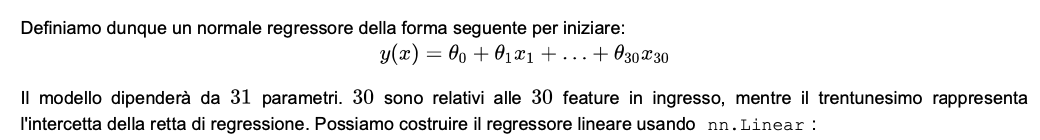

In [14]:
linear_regressor = nn.Linear(30,1)  ## prende in input 30 valori e ce ne ritorna 1 

## applico la f ai nostri dati
z = linear_regressor(X_training_norm)
## valori negativi e positivi. sono chiamati logit
print("primi 10 valori predetti", z[:10])

## questi valori rappresentano gli score z, i logit. Verifichiamo che sia compatibile con la definizione di probabilità

print(z.min(), z.max())

primi 10 valori predetti tensor([[-0.1096],
        [ 0.0380],
        [ 0.2178],
        [ 0.3410],
        [ 0.1903],
        [ 0.4142],
        [-0.0980],
        [-0.0238],
        [ 0.1587],
        [ 0.1500]], grad_fn=<SliceBackward>)
tensor(-0.9687, grad_fn=<MinBackward1>) tensor(1.2384, grad_fn=<MaxBackward1>)


definiamo la funzione logistica di conseguenza per mappare -inf a 0 e +inf a 1 ed inserire i dati in un range accettabile

In [15]:
def logistic(z):
  return 1./(1+torch.exp(-z))

In [16]:
p = logistic(z)
print(p[:10], p.min(), p.max(), "\n")

## oppure utilizzando la proprietaria di pytorch
sigmoid = nn.Sigmoid()  ## f logistica aka sigmoide
p2 = sigmoid(z)
print(p2.min(), p2.max()) ## ottengo gli stessi valori di min e max

tensor([[0.4726],
        [0.5095],
        [0.5542],
        [0.5844],
        [0.5474],
        [0.6021],
        [0.4755],
        [0.4941],
        [0.5396],
        [0.5374]], grad_fn=<SliceBackward>) tensor(0.2751, grad_fn=<MinBackward1>) tensor(0.7753, grad_fn=<MaxBackward1>) 

tensor(0.2751, grad_fn=<MinBackward1>) tensor(0.7753, grad_fn=<MaxBackward1>)


In [17]:
## definisco la funzione di loss o utilizzo quella proprietaria di bceloss
def loss(p,y):
  return (-y*torch.log(p)-(1-y)*torch.log(1-p)).mean()

In [18]:
print(loss(p,Y_training.view(-1,1)))
loss = nn.BCELoss()
print(loss(p,Y_training.view(-1,1)))

tensor(0.6579, grad_fn=<MeanBackward0>)
tensor(0.6579, grad_fn=<BinaryCrossEntropyBackward>)


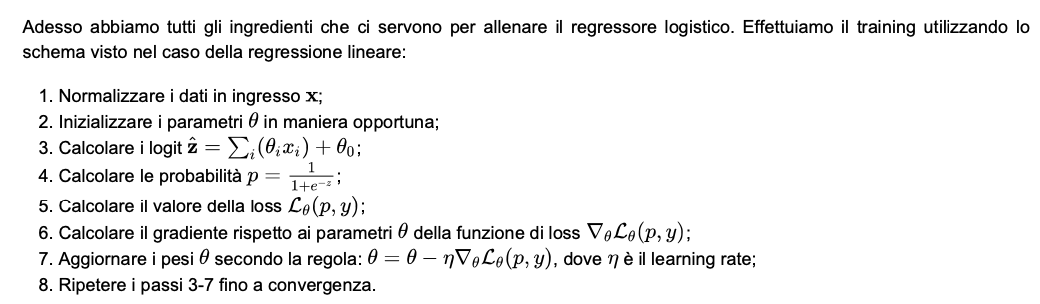

In [19]:
## definiamo un oggetto che effettui la regressione logistica (implementa punto 3 e punto 4)

class LogisticRegressor(nn.Module):
  def __init__(self, in_features):
    """Costruisce un regressore logistico. Input: in_features: numero di feature in input (es. 30)"""
    super(LogisticRegressor, self).__init__() #richiamo il costruttore della su perclasse
    #questo passo è necessario per abilitare alcuni meccanismi automatici dei m oduli di PyTorch
    self.linear = nn.Linear(in_features,1) #il regressore logistico restituisce probabilità
    #quindi il numero di feature di output è "1"
    self.logistic = nn.Sigmoid()  ### definisce un modulo che fa il sigmoide

  def forward(self,x):
    """Definisce come processare l'input x"""
    logits = self.linear(x)

    return self.logistic(logits)

implemento la procedura di training con learning rate a 0.1 e ottimizzando il modello per 500 epoche

In [20]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('logs/logistic_regressor')
lr = 0.01
epochs = 500

# Passo 1: normalizzazione dei dati
means = X_training.mean(0)
stds = X_training.std(0)

X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds

#Passo 2: inizializziamo il modello
regressor = LogisticRegressor(30)

loss = nn.BCELoss()
sgd = torch.optim.SGD(regressor.parameters(), lr)

for e in range(epochs):
  regressor.train()
  #Passo 3 & 4: calcoliamo le probabilità
  p = regressor(X_training_norm)
  #Passo 5: calcoliamo il valore della loss
  l = loss(p, Y_training.view(-1,1))
  #Passo 6: calcoliamo il gradiente della loss rispetto a tutti i parametri
  l.backward()
  #facciamo log del valore della loss
  writer.add_scalar('loss/train', l.item(), global_step=e)
  
  #Passo 7: Aggiorniamo i pesi
  sgd.step()
  #azzeriamo i gradienti per evitare di accumularli
  sgd.zero_grad()
  #calcoliamo e facciamo log la loss di test:
  regressor.eval()
  with torch.set_grad_enabled(False):
    p = regressor(X_testing_norm)
    l = loss(p, Y_testing.view(-1,1))
    writer.add_scalar('loss/test', l.item(), global_step=e)

In [21]:
#iniziamo calcolando le predizioni del modello dati i pesi allenati
p_test = regressor(X_testing_norm)
#calcoliamo il valore della loss
print(loss(p_test, Y_testing.view(-1,1)))

### L'output del regressore logistico consiste in probabilità. Per ottenere le etichette ("0" o "1"), sogliamo le probabilità.
### Tutti gli elementi per i quali abbiamo predetto probabilità maggiore o uguale a saranno di classe , mentre gli altri saranno di classe :

prob_training = regressor(X_training_norm)
prob_testing = regressor(X_testing_norm)
pred_training = prob_training>=0.5      ## prob sup a 0.5 per convenzioni sono arrotondate a 1
pred_testing = prob_testing>=0.5
print(pred_testing[:10])

tensor(0.1860, grad_fn=<BinaryCrossEntropyBackward>)
tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False]])


Adesso abbiamo le etichette predette dal modello. Per capire "quanto" il modello funziona, possiamo confrontare queste predizioni con i valori di ground truth. Iniziamo con una semplice misura di valutazione, l'accuracy, che conta la frazione di elementi per i quali è stata predetta la corretta etichetta:


In [22]:
def accuracy(pred,gt):
  """Calcola l'accuracy date le predizioni pred e le etichette di ground truth gt"""
  correct = pred.view(-1).byte()==gt.view(-1).byte()
  #conterrà true in corrispondenza degli elementi per i quali è stata predetta la classe corretta
  #inseriamo "view(-1)" per essere sicuri di lavorare con array monodimensionali
  return float(correct.sum())/len(correct)#conta il numero di predizioni corrette e divide per il numero totale di predizioni


## calcolo le accuracy di training e test

print("Accuracy di training: {:0.2f}".format(accuracy(pred_training,Y_training)))
print("Accuracy di test: {:0.2f}".format(accuracy(pred_testing,Y_testing)))

Accuracy di training: 0.97
Accuracy di test: 0.93


ricordiamo che per attivare tensroboard da terminale tensroboard --logdir /cartella dove stanno i log

In [23]:
writer = SummaryWriter('logs/logistic_regressor_2')

lr = 0.01
epochs = 500

means = X_training.mean(0)
stds = X_training.std(0)

X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds

regressor = LogisticRegressor(30)

loss = nn.BCELoss()
sgd = torch.optim.SGD(regressor.parameters(), lr)   # optimizier

for e in range(epochs):
    regressor.train()
    p = regressor(X_training_norm)
    l = loss(p, Y_training.view(-1,1))
    l.backward()
    writer.add_scalar('loss/train',l.item(),global_step=e)
    sgd.step()
    sgd.zero_grad()

    writer.add_scalar('accuracy/train',accuracy(p>=0.5,Y_training),global_step=e)   ## scalare che indica l'accuracy del modello. Nella funzione creata passo le etichette

    regressor.eval()
    with torch.set_grad_enabled(False):
        p = regressor(X_testing_norm)
        l = loss(p, Y_testing.view(-1,1))
        writer.add_scalar('loss/test',l.item(),global_step=e)
        #calcoliamo e facciamo log dell'accuracy di training a partire dalle prediz
        writer.add_scalar('accuracy/test',accuracy(p>=0.5,Y_testing),global_step=e)

la loss di test continua a scendere ma l'accuracy non continua a salire. perchè affinchP classifichi bene l'intero testset o trainingse tè sufficiente che tutte le probabilità siano positivi siano maggiori di 0.5, negativi minori di 0.5. 
il modello ha un valore di loss non nullo e un'accuracy elevatissima. Finché c'è le probabilità dei valori negativi non sono tutte uguali a 0 e le probabilità dei valori positivi siano tutte uguali a 1, la cross-entropy non può essere nulla e sarà sempre un valore positivo.
la loss precedentemente usata ha dei problemi di efficienza.

pi è stato calcolato usando la funzione logistica. Abbiamo un problema di instabilità numerica. 

## Stabilità numerica

Con la loss utilizzata precedentemente (formule nel pdf). Può succedere un problema di underflow, il valore "esplode" e il valore va ad 1/0, per cui queste espress.

Invece di applicare una funzione di loss applico una loss calcolata tramite cross-entropy (?)


In [24]:
def loss2(z,y):
    return (y*torch.log(1+torch.exp(-z))+(1-y)*torch.log(1+torch.exp(z))).mean()
## la loss sopra va applicata direttamente ai logit. mentre il nostro modello restituisce direttamente probabiblità. Modifichiamo il modello per restituire i logit invece delle proprietà

class LogisticRegressor(nn.Module):
    def __init__(self, in_features):
        super(LogisticRegressor, self).__init__()
        self.linear = nn.Linear(in_features,1)

    def forward(self,x):
        logits = self.linear(x)
        return logits

Se vogliamo ottenere delle probabilità in fase di test dobbiamo trasformarle manualmente mediante la funzione logistica:

In [25]:
regressor = LogisticRegressor(30)
logistic = nn.Sigmoid()

# logits
z = regressor(X_training_norm)
print(z.min(), z.max())

# probabilità
p = logistic(z)
print(p.min(), p.max()) ## il min non è 0 e il max non è 1 perché va allenato

tensor(-2.5596, grad_fn=<MinBackward1>) tensor(1.4102, grad_fn=<MaxBackward1>)
tensor(0.0718, grad_fn=<MinBackward1>) tensor(0.8038, grad_fn=<MaxBackward1>)


La loss definita precedentemente come loss2 viene implementata da pytorch con il modulo:

In [26]:
loss_stable = nn.BCEWithLogitsLoss()
l_1=loss_stable(z,Y_training.view(-1,1))
l_2=loss2(z,Y_training.view(-1,1)) 
print("LOSS with module     ",l_1)
print("loss with our func   ",l_2)

LOSS with module      tensor(0.8208, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
loss with our func    tensor(0.8208, grad_fn=<MeanBackward0>)


La procedura di training diventa la seguente:

![new loss](img/img-1.png)


In [27]:
writer = SummaryWriter('logs/logistic_regressor_3')

lr = 0.01
epochs = 500
means = X_training.mean(0)
stds = X_training.std(0)

X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds

regressor = LogisticRegressor(30)
#inseriamo qui la nuova loss
loss = nn.BCEWithLogitsLoss()
sgd = torch.optim.SGD(regressor.parameters(), lr)

for e in range(epochs):
    regressor.train()
    z = regressor(X_training_norm)
    l = loss(z, Y_training.view(-1,1))
    l.backward()
    writer.add_scalar('loss/train',l.item(),global_step=e)
    sgd.step()
    sgd.zero_grad()
    #calcoliamo le probabilità
    p=logistic(z)
    writer.add_scalar('accuracy/train',accuracy(p>=0.5,Y_training),global_step=e)
    regressor.eval()
    
    with torch.set_grad_enabled(False):
        z = regressor(X_testing_norm)
        l = loss(z, Y_testing.view(-1,1))
        writer.add_scalar('loss/test',l.item(),global_step=e)
        #calcoliamo le probabilità
        p=logistic(z)
        writer.add_scalar('accuracy/test',accuracy(p>=0.5,Y_testing),global_step=e)

i risultati sono gli stessi ma per calcoli più grandi si nota la differenza

## Valutazione del regressore logistico
scikit-learn mette a disposizione varie misure di valutazione

In [28]:
from sklearn.metrics import accuracy_score

## ottengo le predizioni di training e testing
preds_training = logistic(regressor(X_training_norm))>=0.5
preds_testing = logistic(regressor(X_testing_norm))>=0.5

acc_training = accuracy_score(Y_training,preds_training)
acc_testing = accuracy_score(Y_testing,preds_testing)
print("Accuracy di training:    {:0.2f}".format(acc_training))
print("Accuracy di test:        {:0.2f}".format(acc_testing))


Accuracy di training:    0.97
Accuracy di test:        0.93


In [29]:
## matrice di confusione

from sklearn.metrics import confusion_matrix
cm_training = confusion_matrix(Y_training,preds_training)
cm_testing = confusion_matrix(Y_testing,preds_testing)
print(cm_training)
print(cm_testing)

[[169   6]
 [  6 288]]
[[32  5]
 [ 2 61]]


l'elemento di indici i,j indica il numero di elementi appartenenti alla classe i che è stato classificato come appartenente alla classe j. La matrice di confusione ci da qualche indicazione in più su "dove" si trovano gli errori. Possiamo normalizzare la matrice di confusione per ottenere dei numeri in percentuale:

In [30]:
cm_testing = cm_testing.astype(float)/cm_testing.sum(1).reshape(-1,1)
print(cm_testing)

[[0.86486486 0.13513514]
 [0.03174603 0.96825397]]


## precisione recall

In [31]:
from sklearn.metrics import precision_score, recall_score

precision_training = precision_score(Y_training, preds_training)
precision_test = precision_score(Y_testing, preds_testing)

recall_training = recall_score(Y_training, preds_training)
recall_test = recall_score(Y_testing, preds_testing)

print("Training:    ", precision_training, recall_training) # sul traininset valori + ottimisti
print("Precision:   ", precision_test, recall_test)

Training:     0.9795918367346939 0.9795918367346939
Precision:    0.9242424242424242 0.9682539682539683


#f1 score

numero che va assumere la precision e la reaccl (formula in pdf). Non possiamo ottenere una media armonica alta se non quando entrambi i valori sono alti. In generali se ritorna 0.8 significa che sono abbastanza alti.

In [32]:
from sklearn.metrics import f1_score
scores_training = f1_score(Y_training,preds_training, average=None) ## di default calcola 2 valori nel caso in cui classe . considera 1 caso la classe 1 è positiva e 0 è negativa è 
                                                                    ## viceversa. può essege generalizzato in caso in cui abbiamo più classi
scores_testing = f1_score(Y_testing,preds_testing, average=None)
print(scores_training, ", solo primo elemento:",  f1_score(Y_training,preds_training, average=None)[0])
print(scores_testing)

## è preatica comune calcolare il mean F1 score come la media dei punteggi relativi alle singole classi per ottenere un indicatore generale di performance

print(scores_training.mean())
print(scores_testing.mean())

[0.96571429 0.97959184] , solo primo elemento: 0.9657142857142856
[0.90140845 0.94573643]
0.9726530612244897
0.9235724424063763


## regolarizzazione (weight decay) e momentum

due tecniche che permettono la regolarizazzione (ridurre overfitting) e il momento (accelera la fase di learning). formule su pdf.

l'applicazione della regola di aggiornamenti dei pesi fa "dacadere" epsonenzialmente i pesi. il peso nel tempo decadrà e fa si che non accumulino valori e non diventano enormi (vogliamo la norma piccola). Si applica passando un parametro all'ottimizzatore

````
SGD(model.parameters(),lr, weight_decay = 0.001)
````


In [33]:
writer = SummaryWriter('logs/logistic_regressor_4')

lr = 0.01
epochs = 500
means = X_training.mean(0)
stds = X_training.std(0)

X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds

regressor = LogisticRegressor(30)

loss = nn.BCEWithLogitsLoss()

#specifichiamo il weight_decay
sgd = torch.optim.SGD(regressor.parameters(), lr, weight_decay=0.001)

for e in range(epochs):
    regressor.train()
    z = regressor(X_training_norm)
    l = loss(z, Y_training.view(-1,1))
    l.backward()
    writer.add_scalar('loss/train',l.item(),global_step=e) 
    
    sgd.step()  ## il codice è identico ai precedenti, ma qui l'operazione sarà diversa!
    sgd.zero_grad()
    p = logistic(z)
    writer.add_scalar('accuracy/train',accuracy(p>=0.5,Y_training),global_step=e)
    regressor.eval()

    with torch.set_grad_enabled(False):
        z = regressor(X_testing_norm)
        l = loss(z, Y_testing.view(-1,1))
        writer.add_scalar('loss/test',l.item(),global_step=e)

        p = logistic(z)
        writer.add_scalar('accuracy/test',accuracy(p>=0.5,Y_testing),global_step=e)



print("Accuracy di training: {:0.2f}".format(accuracy(logistic(regressor(X_training_norm))>=0.5,Y_training)))
print("Accuracy di test: {:0.2f}".format(accuracy(logistic(regressor(X_testing_norm))>=0.5,Y_testing)))

Accuracy di training: 0.97
Accuracy di test: 0.92


## momentum

permette di accellerare l'apprendimento. E' sufficiente specificare un parametro momentum al momento della costruzione dell'optimizer

`SGD(model.parameters(),lr, weight_decay = 0.001, momentum=0.9)`

In [34]:
writer = SummaryWriter('logs/logistic_regressor_5')
lr = 0.01
epochs = 500
means = X_training.mean(0)
stds = X_training.std(0)
X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds
regressor = LogisticRegressor(30)
loss = nn.BCEWithLogitsLoss()
#specifichiamo il momentum
sgd = torch.optim.SGD(regressor.parameters(), lr, weight_decay=0.001, momentum=0.9)
for e in range(epochs):
    regressor.train()
    z = regressor(X_training_norm)
    l = loss(z, Y_training.view(-1,1))
    l.backward()
    writer.add_scalar('loss/train',l.item(),global_step=e)
    sgd.step()
    sgd.zero_grad()
    p = logistic(z)
    writer.add_scalar('accuracy/train',accuracy(p>=0.5,Y_training),global_step=e)
    regressor.eval()
    with torch.set_grad_enabled(False):
        z = regressor(X_testing_norm)
        l = loss(z, Y_testing.view(-1,1))
        writer.add_scalar('loss/test',l.item(),global_step=e)
        p = logistic(z)
        writer.add_scalar('accuracy/test',accuracy(p>=0.5,Y_testing),global_step=e)

In [35]:
print("Accuracy di training: {:0.2f}".format(accuracy(regressor(X_training_norm)>= 0.5,Y_training)))
print("Accuracy di test: {:0.2f}".format(accuracy(regressor(X_testing_norm)>=0.5,Y_testing)))

Accuracy di training: 0.99
Accuracy di test: 0.96
